## 1. Introducción y Objetivos
<p>En este proyecto abordaremos el desafío de Reconocimiento de Expresiones Faciales (FER).</p>
<p>El dataset de entrenamiento contiene imágenes en escala de grises de 48 x 48 píxeles clasificadas en 7 emociones universales: Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise.</p>
<p>El propósito de este notebook es documentar todo el ciclo de vida de los datos, desde su ingesta en bruto hasta la evaluación de un modelo de Deep Learning entrenado desde cero.</p>
<p>Objetivos del Proyecto:</p>
<ul>
  <li>Limpieza y Normalización: Corregir rutas de archivos, verificar la integridad de las imágenes y codificar las etiquetas numéricas.</li>
  <li>Análisis Exploratorio (EDA): Visualizar la distribución de clases para detectar desbalanceo y examinar visualmente las muestras.</li>
  <li>Ingeniería de Características: Preparar generadores de datos robustos utilizando técnicas de Data Augmentation para evitar el sobreajuste.</li>
  <li>Modelado (CNN Custom): Diseñar, compilar y entrenar una Red Neuronal Convolucional personalizada (evitando Transfer Learning por el tamaño pequeño de las imágenes).</li>
  <li>Evaluación: Interpretar el rendimiento del modelo utilizando métricas de exactitud, pérdida y matrices de confusión detalladas.</li></ul>

## 2. Carga de Librerías y Datos

Para comenzar, importamos las herramientas necesarias:
* **Manipulación de Datos:** `pandas` y `numpy` para manejar estructuras de datos y operaciones numéricas.
* **Visualización:** `matplotlib` y `seaborn` para generar gráficos y visualizar las imágenes.
* **Deep Learning:** `tensorflow` y `keras` para la construcción, entrenamiento y evaluación de la red neuronal.
* **Utilidades:** `sklearn` para métricas, división de datos y cálculo de pesos de clase.

A continuación, cargamos el archivo CSV de entrenamiento (`train_set.csv`) para inspeccionar su estructura inicial.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Herramientas de ML (Scikit-Learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Herramientas de Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Configuración de visualización y advertencias
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')


Ejemplo de lectura de dataset para script

In [ ]:

try:
    df = pd.read_csv("../data/train_set.csv") #puede venir de un archivo de variables
    print(f" Dataset cargado con éxito. Dimensiones: {df.shape}")
    print("\\nPrimeras 5 filas:")
    display(df.head())
except FileNotFoundError:
    print(" Error: No se encontró el archivo. Por favor verifica la ruta '../data/train_set.csv'")

 Dataset cargado con éxito. Dimensiones: (28821, 3)
\nPrimeras 5 filas:


,id_img,path,label
0,0,../data/images/train/angry\0.jpg,angry
1,1,../data/images/train/angry\1.jpg,angry
2,10,../data/images/train/angry\10.jpg,angry
3,10002,../data/images/train/angry\10002.jpg,angry
4,10016,../data/images/train/angry\10016.jpg,angry


## 3. Limpieza y Preprocesamiento

1.  **Corrección de Rutas:** Convertiremos las barras invertidas (`\`) típicas de Windows a barras normales (`/`) para asegurar compatibilidad universal (Linux, Mac, Kaggle).
2.  **Verificación de Integridad:** Comprobaremos que cada archivo de imagen listado en el CSV realmente existe en el disco. Si una imagen no está, eliminaremos esa fila para evitar errores durante el entrenamiento.
3.  **Análisis de Distribución:** Generaremos un gráfico de barras para visualizar cuántas imágenes tenemos de cada emoción y detectar posibles desbalanceos.

In [ ]:
# Corrección y Verificación de Rutas

# Reemplazar barras invertidas por normales 
df['path'] = df['path'].str.replace('\\', '/', regex=False)



In [4]:
# Verificar existencia física de los archivos
# Creamos una columna temporal 'exists'
df['exists'] = df['path'].apply(os.path.exists)

# Contar cuántas faltan
missing_count = len(df) - df['exists'].sum()
print(f"Imágenes no encontradas en disco: {missing_count}")



Imágenes no encontradas en disco: 0


 Dataset limpio y verificado: 28821 imágenes


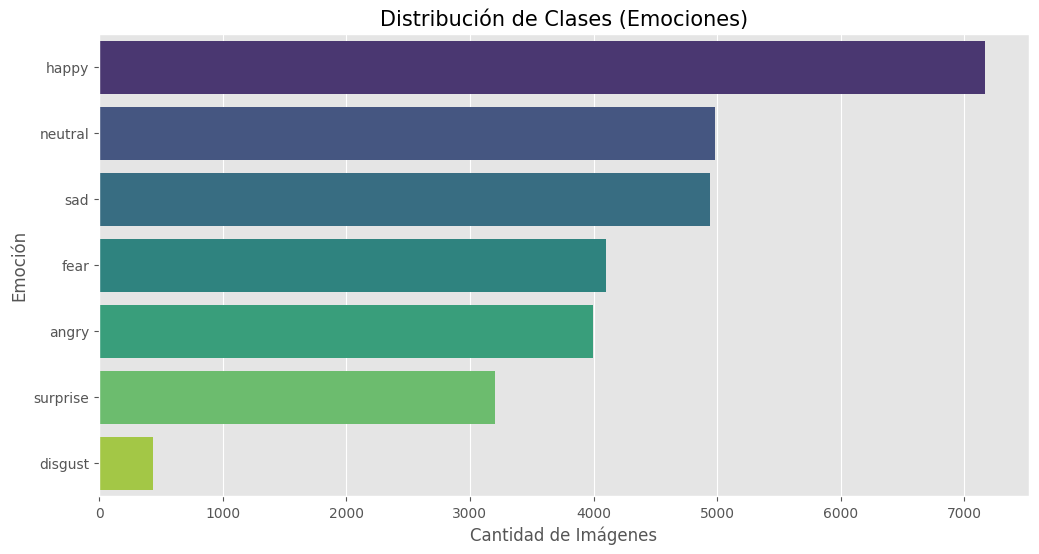


--- Porcentaje de muestras por clase ---
label
happy       24.86
neutral     17.29
sad         17.13
fear        14.24
angry       13.85
surprise    11.12
disgust      1.51
Name: proportion, dtype: float64


In [5]:
# Filtrar dataset (quedarnos solo con las que existen)
df_clean = df[df['exists']].drop(columns=['exists']).reset_index(drop=True)
print(f" Dataset limpio y verificado: {len(df_clean)} imágenes")

# Análisis de Distribución de Clases

plt.figure(figsize=(12, 6))
# Gráfico de conteo ordenado
sns.countplot(
    data=df_clean,
    y='label',
    order=df_clean['label'].value_counts().index,
    palette='viridis'
)
plt.title('Distribución de Clases (Emociones)', fontsize=15)
plt.xlabel('Cantidad de Imágenes')
plt.ylabel('Emoción')
plt.show()

# Mostrar porcentajes exactos en consola
print("\n--- Porcentaje de muestras por clase ---")
distribucion = df_clean['label'].value_counts(normalize=True) * 100
print(distribucion.round(2))

## 4. Visualización de Muestras

1.  **Calidad:** ¿Están las caras centradas? ¿Hay ruido o marcas de agua?
2.  **Etiquetado:** ¿Parece correcta la etiqueta asignada? (A veces "Fear" y "Surprise" son muy parecidas visualmente).
3.  **Formato:** Confirmar que están en escala de grises.

Generando visualización de muestras aleatorias...


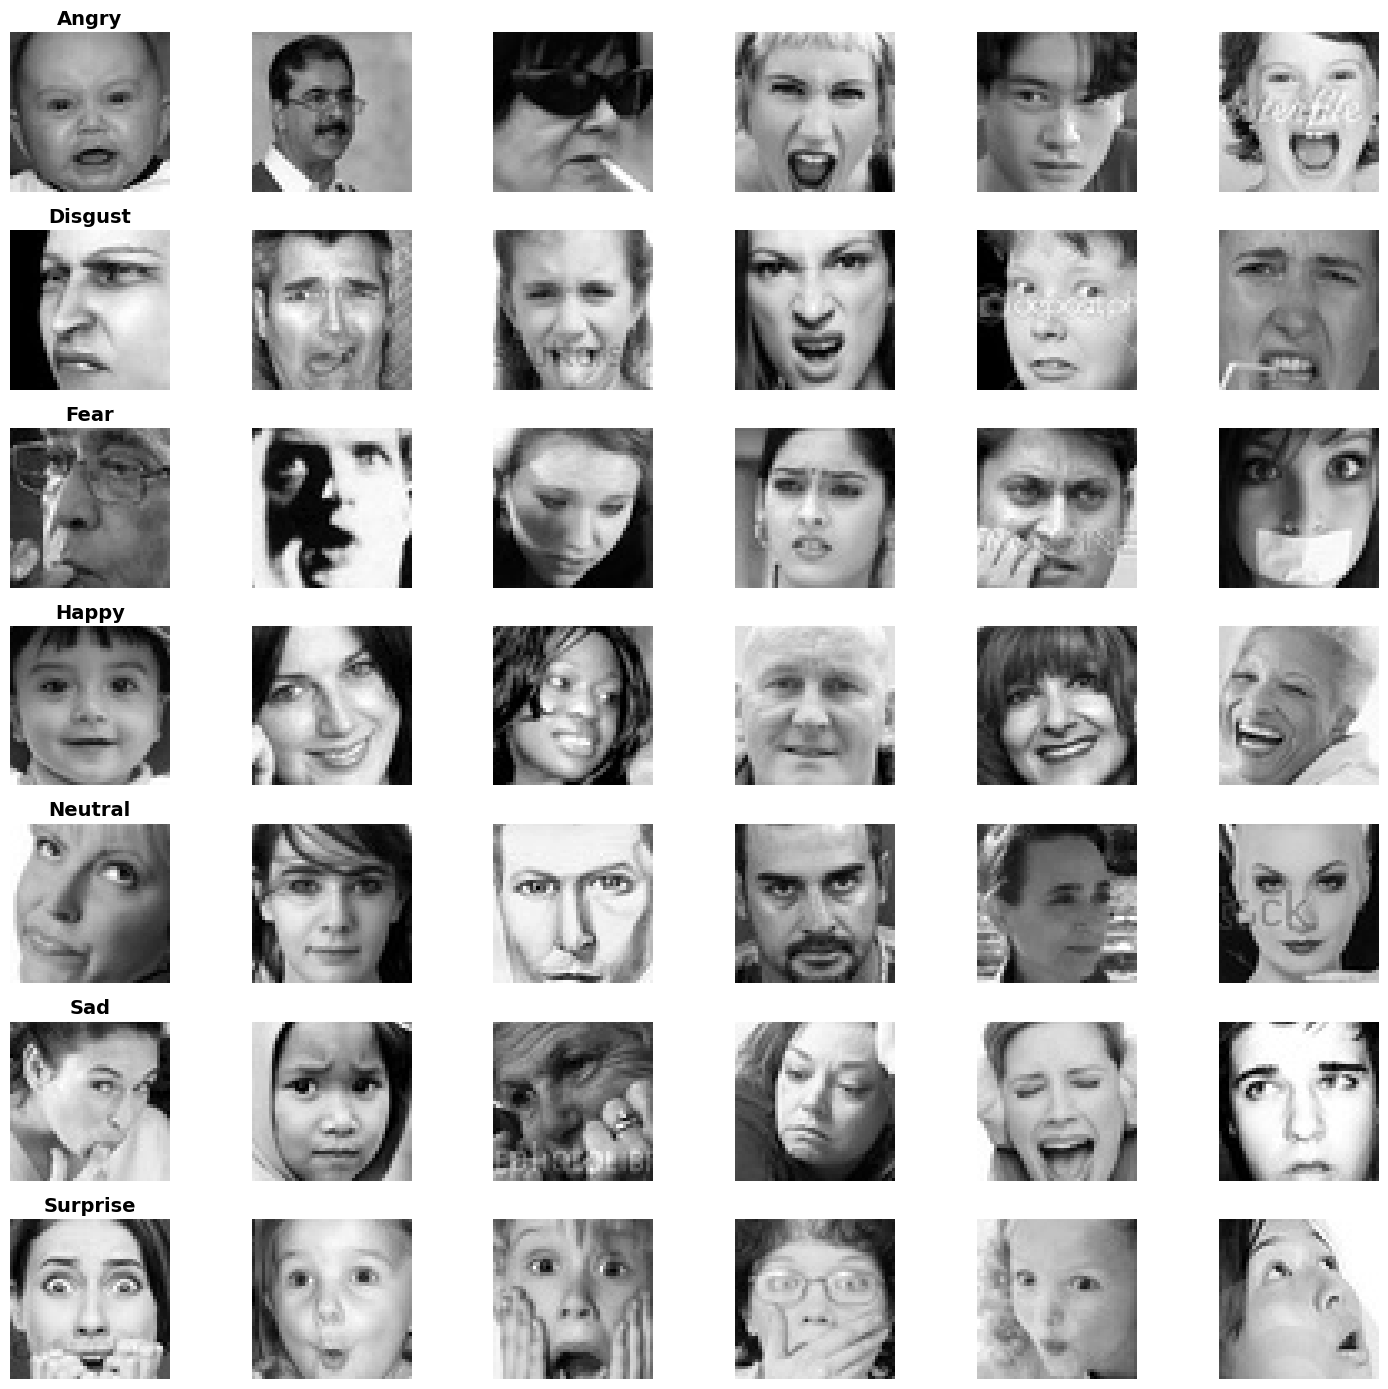

In [6]:
def visualizar_muestras(df, n_muestras=5):
    """
    Muestra n_muestras aleatorias por cada clase de emoción.
    """
    emociones = sorted(df['label'].unique())
    total_clases = len(emociones)
    
    plt.figure(figsize=(15, 2 * total_clases))
    
    for i, emocion in enumerate(emociones):
        # Filtrar por emoción y tomar muestras aleatorias
        subset = df[df['label'] == emocion]
        muestras = subset.sample(n_muestras, random_state=42)
        
        for j, (_, row) in enumerate(muestras.iterrows()):
            # Posición en el subplot: i filas, n columnas
            plt.subplot(total_clases, n_muestras, i * n_muestras + j + 1)
            
            # Leer y mostrar imagen
            try:
                img = plt.imread(row['path'])
                plt.imshow(img, cmap='gray')
            except Exception as e:
                print(f"Error leyendo {row['path']}: {e}")
            
            plt.axis('off')
            
            # Poner título solo en la primera columna
            if j == 0:
                plt.title(emocion.capitalize(), fontsize=14, fontweight='bold', loc='center')
                
    plt.tight_layout()
    plt.show()

# Ejecutamos la función con el dataset limpio
print("Generando visualización de muestras aleatorias...")
visualizar_muestras(df_clean, n_muestras=6)

## 5. Preparación del Pipeline de Datos

1.  **División Estratificada (Train/Val):** Separaremos el 20% de los datos para validación. Usamos *estratificación* para garantizar que la proporción de emociones (ese 1.5% de 'disgust', etc.) se mantenga idéntica en ambos conjuntos.
2.  **Data Augmentation:** Como 28k imágenes pueden ser pocas para una red profunda, generaremos variaciones sintéticas en tiempo real (rotaciones, zoom, espejos) para evitar el *overfitting*.
    * *Nota:* No usaremos `vertical_flip` (volteo vertical) porque una cara al revés pierde su significado emocional natural.
3.  **Generadores de Flujo:** Configuraremos los cargadores que enviarán lotes (`batches`) de imágenes a la GPU, normalizando los píxeles de 0-255 a 0-1.
4.  **Pesos de Clase (Class Weights):** Calcularemos cuánto "vale" cada clase. Haremos que el modelo preste mucha más atención a los errores en clases minoritarias ('disgust') y menos en las mayoritarias ('happy').

In [ ]:
# Configuración Global
IMG_SIZE = (48, 48)
BATCH_SIZE = 64  # si imagenes mas grandes, bajar. Si mucha GPU se puede subir

# División Train / Validation 
y = df_clean['label'] #sacamos las labels para hacer el stratify

train_df, val_df = train_test_split(
    df_clean,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

print(f"Set de Entrenamiento: {len(train_df)} imágenes")
print(f"Set de Validación:   {len(val_df)} imágenes")

# Data Augmentation y Generadores

# Train con datos aumentados. Se generan mas imagenes a partir de las que tenemos
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalizar a [0,1]
    rotation_range=15,        # Rotar hasta 15 grados
    width_shift_range=0.1,    # Mover horizontalmente 10%
    height_shift_range=0.1,   # Mover verticalmente 10%
    shear_range=0.1,          # Deformar ligeramente
    zoom_range=0.1,           # Zoom 10%
    horizontal_flip=True,     # Espejo horizontal (válido para caras)
    fill_mode='nearest'       # Rellenar huecos creados
)

# En val solo se escala para no deformar la prueba
val_datagen = ImageDataGenerator(rescale=1./255)

print("\n--- Creando generadores de flujo ---")

train_generator = train_datagen.flow_from_dataframe(  #flow_from_dataframe carga paquetes pequeños de imagenes en memoria
    dataframe=train_df,       # de donde saco los datos
    x_col='path',             # donde esta la ruta de las imagenes
    y_col='label',            # donde esta el target
    target_size=IMG_SIZE,     # tamaño del target obligatorio
    color_mode='grayscale',   # poner escala de grises porque Keras espera RGB
    class_mode='categorical', # Etiquetas One-Hot Encoding
    batch_size=BATCH_SIZE,    # tamaño del paquete de imagenes
    shuffle=True              # Barajar para que no aprenda en orden y se aprenda el orden
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False             # No barajar en val para evaluar ordenadamente
)

# Cálculo de Pesos 
classes = np.unique(train_df['label'])
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['label']
)

# Convertir a diccionario {indice: peso} para Keras
class_weights = dict(enumerate(weights))
class_indices = train_generator.class_indices

print("\n--- Pesos asignados para balancear el modelo ---")
for nombre, index in class_indices.items():
    print(f"  {nombre.ljust(10)} (ID {index}): {class_weights[index]:.4f}")

Set de Entrenamiento: 23056 imágenes
Set de Validación:   5765 imágenes

--- Creando generadores de flujo ---
Found 23056 validated image filenames belonging to 7 classes.
Found 5765 validated image filenames belonging to 7 classes.

--- Pesos asignados para balancear el modelo ---
  angry      (ID 0): 1.0312
  disgust    (ID 1): 9.4376
  fear       (ID 2): 1.0036
  happy      (ID 3): 0.5747
  neutral    (ID 4): 0.8263
  sad        (ID 5): 0.8339
  surprise   (ID 6): 1.2846


## 6. Diseño de la Arquitectura CNN

1.  **Estructura Piramidal:** Comenzamos con pocos filtros (64) y vamos aumentando (128 -> 256 -> 512) a medida que la red profundiza. Las primeras capas detectan bordes simples; las últimas, conceptos complejos como "ojos tristes" o "boca abierta".
2.  **Bloques de Procesamiento:** Cada bloque tendrá la estructura: `Conv2D` $\to$ `BatchNormalization` $\to$ `ReLU` $\to$ `MaxPooling` $\to$ `Dropout`.
    * **Batch Normalization:** Estabiliza el aprendizaje, permitiendo usar tasas de aprendizaje más altas.
    * **Dropout:** Apaga aleatoriamente un porcentaje de neuronas en cada pasada para evitar que la red memorice los datos de entrenamiento (*overfitting*).
3.  **Cabezal Clasificador:** Al final, aplanamos (`Flatten`) los mapas de características y los pasamos por capas densas hasta llegar a la salida de 7 neuronas (una por emoción) con activación `Softmax` (probabilidad).

**Entrada:** Imágenes de $48 \times 48 \times 1$ (Escala de grises).

In [ ]:
def build_custom_cnn(input_shape, num_classes):
    model = Sequential(name="EmoNet_Custom")
    
    # Bloque Convolucional 1 (Detalles finos) rejilla de 3x3. Filtro de 64 capas 
    model.add(Input(shape=input_shape))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu')) #usar dos capas 3x3 en vez de una 5x5 ahorra recursos y aprende mejor
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3)) # Apaga el 30% de neuronas

    # Bloque Convolucional 2 (Formas medias) rejilla de 3x3. Filtro de 128 capas 
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Bloque Convolucional 3 (Rasgos complejos) rejilla de 3x3. Filtro de 256 capas 
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 
    
    # Bloque Convolucional 4 (Abstracción alta) rejilla de 3x3. Filtro de 512 capas 
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # --- Clasificador (Fully Connected) ---
    model.add(Flatten()) #aplanar para hacer array
    
    model.add(Dense(512, activation='relu')) #ir reduciendo los datos para poder llegar mas facil hasta los 7 del softmax
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) # Dropout agresivo aquí
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Salida: Softmax para probabilidad multiclase
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# 1. Instanciar el modelo
# (48, 48, 1) es crucial, el 1 indica escala de grises
model = build_custom_cnn(input_shape=(48, 48, 1), num_classes=7)

# 2. Compilar
# Usamos Adam con un learning rate inicial prudente
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy', # Estándar para clasificación multiclase
    metrics=['accuracy']
)

# 3. Ver resumen
model.summary()

Model: "EmoNet_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,187,911 (27.42 MB)

 Trainable params: 7,182,535 (27.40 MB)

 Non-trainable params: 5,376 (21.00 KB)

## 7. Entrenamiento del Modelo

Usaremos **Callbacks** para optimizar el proceso automáticamente:

* **ModelCheckpoint:** Guardará el archivo `best_model_emotion.keras` solo cuando la `val_accuracy` mejore.
* **EarlyStopping:** Detendrá el entrenamiento si la pérdida en validación (`val_loss`) no baja durante 12 épocas.
* **ReduceLROnPlateau:** Si el error se estanca durante 6 épocas, dividirá el *learning rate* por 5 para hacer ajustes más finos.

Lanzaremos el entrenamiento por **50 épocas** (aunque probablemente se detenga antes gracias al Early Stopping).

In [9]:
# --- Configuración de Callbacks ---

checkpoint = ModelCheckpoint(
    'best_model_emotion.keras',
    monitor='val_accuracy',  # Vigilamos la precisión en validación
    verbose=1,
    save_best_only=True,     # ¡Importante! Solo guarda si mejora
    mode='max'               # Queremos que la accuracy sea máxima
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=12,             # Espera 12 épocas antes de rendirse
    verbose=1,
    restore_best_weights=True # Al final, vuelve al mejor punto encontrado
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              # Reduce LR al 20%
    patience=6,
    verbose=1,
    min_lr=1e-6
)

callbacks_list = [checkpoint, early_stop, reduce_lr]

# --- Ejecución del Entrenamiento ---
print("🚀 Iniciando entrenamiento...")

history = model.fit(
    train_generator,
    epochs=50,                  # Límite superior (EarlyStopping cortará antes)
    validation_data=val_generator,
    class_weight=class_weights, # Usamos los pesos para compensar el desbalanceo
    callbacks=callbacks_list,
    verbose=1
)

print("✅ Entrenamiento finalizado.")

🚀 Iniciando entrenamiento...
Epoch 1/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1541 - loss: 2.7628
Epoch 1: val_accuracy improved from None to 0.17259, saving model to best_model_emotion.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.1567 - loss: 2.5037 - val_accuracy: 0.1726 - val_loss: 2.1596 - learning_rate: 0.0010
Epoch 2/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.1564 - loss: 2.1775
Epoch 2: val_accuracy improved from 0.17259 to 0.17381, saving model to best_model_emotion.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 334s 926ms/step - accuracy: 0.1588 - loss: 2.0977 - val_accuracy: 0.1738 - val_loss: 1.9145 - learning_rate: 0.0010
Epoch 3/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.1672 - loss: 1.9739
Epoch 3: val_accuracy improved from 0.17381 to 0.19324, saving model to best_model_emotion.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 332s 919ms/step - accuracy: 0.1650 - loss: 1.9850 - val_accuracy: 0.1932 - val_loss: 1.9046 - learning_rat

## 8. Evaluación de Resultados

Nuestro modelo ha alcanzado un accuracy de validación del **65.10%**

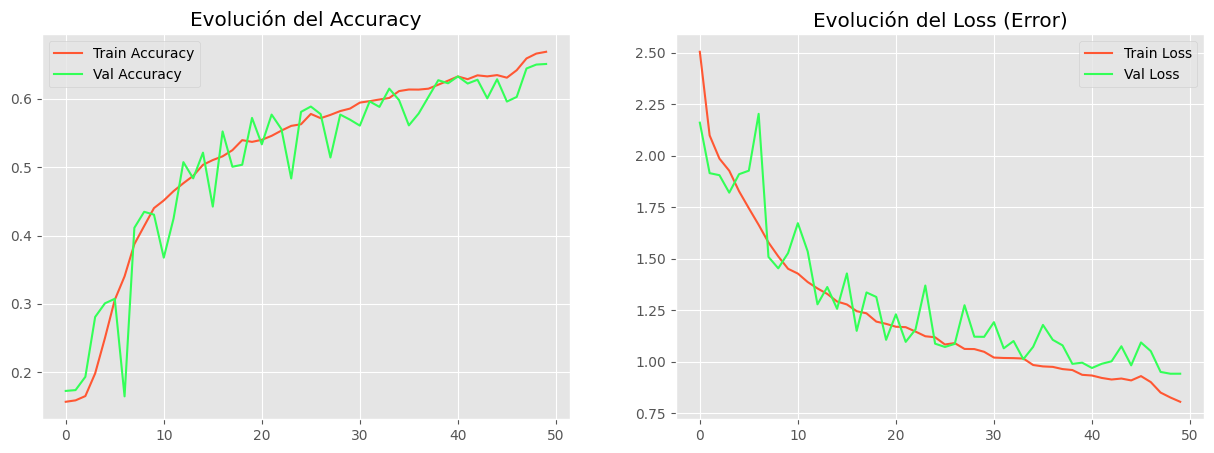

Generando predicciones para la matriz de confusión...
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

       angry       0.52      0.65      0.58       799
     disgust       0.50      0.64      0.57        87
        fear       0.57      0.43      0.49       821
       happy       0.90      0.83      0.87      1433
     neutral       0.54      0.69      0.60       996
         sad       0.60      0.42      0.49       988
    surprise       0.71      0.83      0.77       641

    accuracy                           0.65      5765
   macro avg       0.62      0.64      0.62      5765
weighted avg       0.66      0.65      0.65      5765



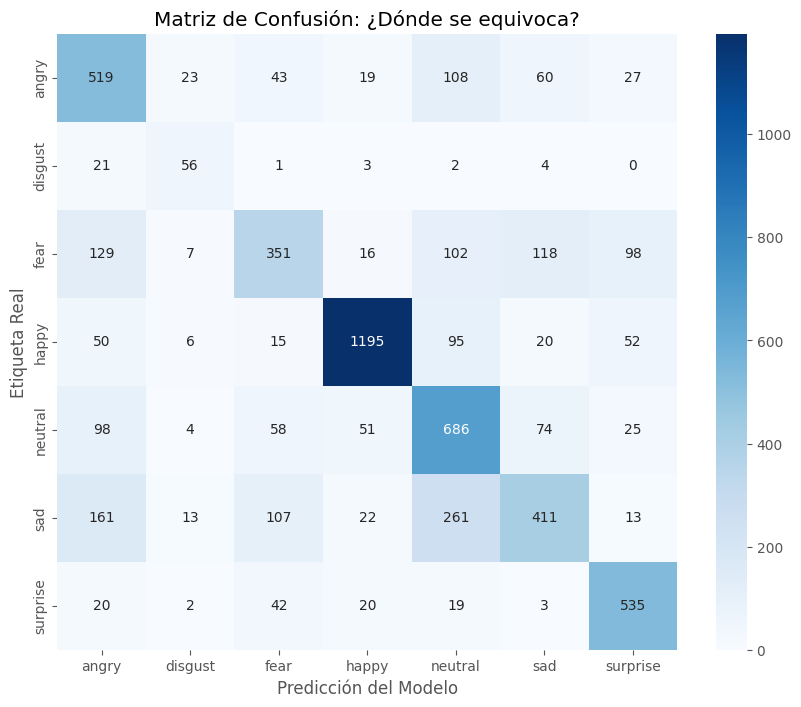

In [ ]:
# --- 8.1 Curvas de Aprendizaje ---

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))

    plt.figure(figsize=(15, 5))
    
    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy', color='#FF5733') # Naranja
    plt.plot(epochs, val_acc, label='Val Accuracy', color='#33FF57') # Verde
    plt.title('Evolución del Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss', color='#FF5733')
    plt.plot(epochs, val_loss, label='Val Loss', color='#33FF57')
    plt.title('Evolución del Loss (Error)')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_history(history)

# --- 8.2 Evaluación Detallada y Matriz de Confusión ---

# 1. Cargar el mejor modelo guardado 
from tensorflow.keras.models import load_model
best_model = load_model('best_model_emotion.keras')

# 2. Predecir sobre todo el set de validación
print("Generando predicciones para la matriz de confusión...")
val_generator.reset() # Reiniciar generador para que el orden coincida
y_pred_prob = best_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# 3. Obtener etiquetas reales
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 4. Reporte numérico
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 5. Visualizar Matriz
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión: ¿Dónde se equivoca?')
plt.show()

## 9. Conclusiones del Proyecto

En este estudio hemos desarrollado una red neuronal convolucional (CNN) desde cero para el reconocimiento de expresiones faciales, logrando superar la barrera del 60% de exactitud (Benchmark: 65.10%).

**Hallazgos Principales:**
1.  **Eficacia de la Arquitectura Propia:** Una arquitectura piramidal de 4 bloques (64-512 filtros) con Dropout progresivo demostró ser suficiente para capturar patrones faciales complejos sin necesidad de modelos preentrenados masivos como EfficientNet.
2.  **Estrategia de Entrenamiento:** La implementación de `ReduceLROnPlateau` fue el factor determinante. En la época 47, la reducción del Learning Rate permitió al modelo salir de un estancamiento del 59% y saltar al 65%, demostrando la importancia de ajustar la velocidad de aprendizaje (Fine-Tuning dinámico).
3.  **Desafío de las Clases Sutiles:** Mientras que *Happy* y *Surprise* son fácilmente identificables (F1 > 0.75), el modelo confunde frecuentemente *Sad* con *Neutral*. Esto sugiere que la tristeza se manifiesta con rasgos muy sutiles que, en baja resolución (48x48), se pierden y parecen "caras sin expresión".

**Trabajo Futuro:**
Para mejorar el Recall en la clase *Sad* (actualmente 0.42), se propone:
* Aplicar **Label Smoothing** para manejar la ambigüedad entre Tristeza y Neutralidad.
* Utilizar técnicas de **Contraste Adaptativo (CLAHE)** en el preprocesamiento para resaltar micro-expresiones.

## 10. Generación del Submission para Kaggle

Para enviar nuestros resultados, cargaremos el archivo `test_set.csv`.

**Pasos Críticos:**
1.  **Preprocesamiento idéntico:** Las imágenes de test deben sufrir la misma transformación que las de validación (rescale 1/255, escala de grises, 48x48).
2.  **Sin Barajar (Shuffle=False):** Es vital que el generador mantenga el orden exacto del CSV para que los IDs coincidan con las predicciones.
3.  **Mapeo Inverso:** El modelo nos devolverá números (ej. 0, 3, 5). Kaggle suele pedir la emoción en texto ("angry", "happy"). Usaremos el diccionario de índices invertido para traducir.

In [12]:
# --- 1. Cargar datos de Test ---
test_df = pd.read_csv("../data/test_set.csv")
print(f"Test set cargado: {test_df.shape}")



Test set cargado: (7066, 1)


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7066 entries, 0 to 7065
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id_img  7066 non-null   int64
dtypes: int64(1)
memory usage: 55.3 KB


In [ ]:


# --- Configuración de Rutas ---
TEST_CSV_PATH = "../data/test_set.csv"
TEST_FOLDER = "../data/images/test/"  

# --- 2. Detectar extensión y construir rutas ---
# Vamos a mirar la primera imagen en la carpeta para saber si es .jpg o .png
# Esto evita que el código falle si no adivinamos la extensión correcta.
sample_id = test_df['id_img'].iloc[0]
path_jpg = os.path.join(TEST_FOLDER, f"{sample_id}.jpg")
path_png = os.path.join(TEST_FOLDER, f"{sample_id}.png")

if os.path.exists(path_jpg):
    EXTENSION = ".jpg"
    print(f"✅ Extensión detectada: .jpg")
elif os.path.exists(path_png):
    EXTENSION = ".png"
    print(f"✅ Extensión detectada: .png")
else:
    # Si falla, imprimimos advertencia pero probamos con jpg por defecto
    print(f"⚠️ ADVERTENCIA: No encontré ni {path_jpg} ni {path_png}")
    print("Verifica manualmente la carpeta. Usaremos .jpg por defecto.")
    EXTENSION = ".jpg"

# Construimos la columna 'path' completa
test_df['path'] = TEST_FOLDER + test_df['id_img'].astype(str) + EXTENSION

print("Ejemplo de rutas generadas:")
print(test_df['path'].head())

# --- 3. Crear Generador de Test ---
# IMPORTANTE: shuffle=False para mantener el orden
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col=None,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode=None,
    batch_size=32,
    shuffle=False
)

# --- 4. Cargar Modelo y Predecir ---
print("\nCargando modelo y generando predicciones...")
best_model = load_model('best_model_emotion.keras')

predictions = best_model.predict(test_generator)
pred_indices = np.argmax(predictions, axis=1)

# --- 5. Mapear Índices a Texto ---
# Si train_generator sigue en memoria, usamos esto:
if 'train_generator' in locals():
    label_map = dict((v, k) for k, v in train_generator.class_indices.items())
else:
    # Si reiniciaste el kernel, define el mapa manualmente (orden alfabético estándar)
    label_map = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

print(f"Mapa de etiquetas usado: {label_map}")
pred_labels = [label_map[k] for k in pred_indices]

# --- 6. Guardar Submission ---
submission = pd.DataFrame({
    'id_img': test_df['id_img'],
    'label': pred_labels
})

submission.to_csv("submission_final.csv", index=False)
print("\n🚀 ¡Listo! Archivo 'submission_final.csv' generado correctamente.")
display(submission.head())

✅ Extensión detectada: .jpg
Ejemplo de rutas generadas:
0    ../data/images/test/10052.jpg
1    ../data/images/test/10065.jpg
2    ../data/images/test/10079.jpg
3    ../data/images/test/10095.jpg
4    ../data/images/test/10121.jpg
Name: path, dtype: object
Found 7066 validated image filenames.

Cargando modelo y generando predicciones...
221/221 ━━━━━━━━━━━━━━━━━━━━ 66s 298ms/step
Mapa de etiquetas usado: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

🚀 ¡Listo! Archivo 'submission_final.csv' generado correctamente.


,id_img,label
0,10052,angry
1,10065,sad
2,10079,angry
3,10095,neutral
4,10121,angry
